# Indoor Localization using Deep Neural Network

###  Load Libraries and Dataset

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, hamming_loss, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense, Dropout
import plotly.express as px
import matplotlib.animation as animation

# Load dataset
data = pd.read_csv(r'C:\Users\Hp\OneDrive\Indoor Localization using RSSI Dataset\archive (1)\TrainingData.csv')

# Display first few rows
data.head()


,WAP001,WAP002,WAP003,WAP004,WAP005,WAP006,WAP007,WAP008,WAP009,WAP010,...,WAP520,LONGITUDE,LATITUDE,FLOOR,BUILDINGID,SPACEID,RELATIVEPOSITION,USERID,PHONEID,TIMESTAMP
0,100,100,100,100,100,100,100,100,100,100,...,100,-7541.2643,4.864921e+06,2,1,106,2,2,23,1371713733
1,100,100,100,100,100,100,100,100,100,100,...,100,-7536.6212,4.864934e+06,2,1,106,2,2,23,1371713691
2,100,100,100,100,100,100,100,-97,100,100,...,100,-7519.1524,4.864950e+06,2,1,103,2,2,23,1371714095
3,100,100,100,100,100,100,100,100,100,100,...,100,-7524.5704,4.864934e+06,2,1,102,2,2,23,1371713807
4,100,100,100,100,100,100,100,100,100,100,...,100,-7632.1436,4.864982e+06,0,0,122,2,11,13,1369909710


###  Preprocessing: Splitting the Dataset into Train and Test Data

In [5]:
# Features (RSSI columns) and target variables (LONGITUDE, LATITUDE, etc.)
continuous_columns = ['LONGITUDE', 'LATITUDE', 'TIMESTAMP']
categorical_columns = ['FLOOR', 'BUILDINGID', 'SPACEID', 'RELATIVEPOSITION', 'USERID', 'PHONEID']

X = data.drop(continuous_columns + categorical_columns, axis=1)  # RSSI features
y_continuous = data[continuous_columns]  # Continuous target variables
y_categorical = data[categorical_columns].copy()  # Create a copy to avoid warnings

# Encoding categorical columns
label_encoders = {}
for col in categorical_columns:
    label_encoders[col] = LabelEncoder()
    y_categorical.loc[:, col] = label_encoders[col].fit_transform(y_categorical[col])  # Use .loc here

# Splitting into train and test sets
X_train, X_test, y_train_continuous, y_test_continuous = train_test_split(
    X, y_continuous, test_size=0.2, random_state=42
)
y_train_categorical, y_test_categorical = train_test_split(
    y_categorical, test_size=0.2, random_state=42
)

# Standardizing the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


### DNN Model Definition and Training

In [7]:
from keras.models import Model
from keras.layers import Input, Dense

# Function to create a DNN model with two outputs
def create_dnn_model(input_shape):
    # Input layer
    inputs = Input(shape=(input_shape,))
    
    # Hidden layers
    x = Dense(128, activation='relu')(inputs)
    x = Dense(64, activation='relu')(x)
    
    # Continuous output
    continuous_output = Dense(len(continuous_columns), activation='linear', name='continuous_output')(x)
    
    # Categorical output
    categorical_output = Dense(len(categorical_columns), activation='softmax', name='categorical_output')(x)
    
    # Creating the model with two outputs
    model = Model(inputs=inputs, outputs=[continuous_output, categorical_output])
    
    # Compiling the model
    model.compile(optimizer='adam', 
                  loss=['mse', 'categorical_crossentropy'], 
                  metrics=['mae', 'accuracy'])
    
    return model


In [8]:
# Define and train the model
dnn_model = create_dnn_model(X_train.shape[1])
history = dnn_model.fit(X_train, [y_train_continuous, y_train_categorical],
                        epochs=50, batch_size=32,
                        validation_data=(X_test, [y_test_continuous, y_test_categorical]))


Epoch 1/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - categorical_output_accuracy: 0.7678 - continuous_output_mae: 458761120.0000 - loss: 626936170038689792.0000 - val_categorical_output_accuracy: 0.9631 - val_continuous_output_mae: 458696896.0000 - val_loss: 626838657101201408.0000
Epoch 2/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - categorical_output_accuracy: 0.9656 - continuous_output_mae: 458628352.0000 - loss: 626747191477665792.0000 - val_categorical_output_accuracy: 0.9631 - val_continuous_output_mae: 458255648.0000 - val_loss: 626210698522787840.0000
Epoch 3/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - categorical_output_accuracy: 0.9611 - continuous_output_mae: 458045728.0000 - loss: 625919602819334144.0000 - val_categorical_output_accuracy: 0.9631 - val_continuous_output_mae: 457189792.0000 - val_loss: 624673924864540672.0000
Epoch 4/50
499/499 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - categorical_output_accuracy: 0.9631 - continuous_output_mae: 456819488.0000 - loss: 6241024536

### Evaluation and Metrics

In [13]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, hamming_loss, mean_absolute_error

def print_metrics(y_true_cont, y_pred_cont, y_true_cat, y_pred_cat):
    # For continuous predictions, we might want to use regression metrics
    # Mean Absolute Error (MAE) for continuous outputs
    mae_continuous = mean_absolute_error(y_true_cont, y_pred_cont)
    print("Mean Absolute Error (MAE):", mae_continuous)

    # For categorical predictions, use classification metrics
    # Convert one-hot encoded predictions back to class labels if necessary
    y_pred_cat_labels = np.argmax(y_pred_cat, axis=1)
    y_true_cat_labels = np.argmax(y_true_cat, axis=1)

    print("Accuracy:", accuracy_score(y_true_cat_labels, y_pred_cat_labels))
    print("Precision:", precision_score(y_true_cat_labels, y_pred_cat_labels, average='weighted'))
    print("Recall:", recall_score(y_true_cat_labels, y_pred_cat_labels, average='weighted'))
    print("F1 Score:", f1_score(y_true_cat_labels, y_pred_cat_labels, average='weighted'))
    print("Hamming Loss:", hamming_loss(y_true_cat_labels, y_pred_cat_labels))


In [14]:
# Generate predictions
y_pred_continuous, y_pred_categorical = dnn_model.predict(X_test)

# Call the print_metrics function with the predictions and true values
print_metrics(y_test_continuous, y_pred_continuous, y_test_categorical, y_pred_categorical)


125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Mean Absolute Error (MAE): 51536443.67181402
Accuracy: 0.9631394182547643
Precision: 0.9276375389961259
Recall: 0.9631394182547643
F1 Score: 0.9450551808702388
Hamming Loss: 0.03686058174523571


c:\Users\Hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


###  Correlation, Histograms, and Scatter Plots

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

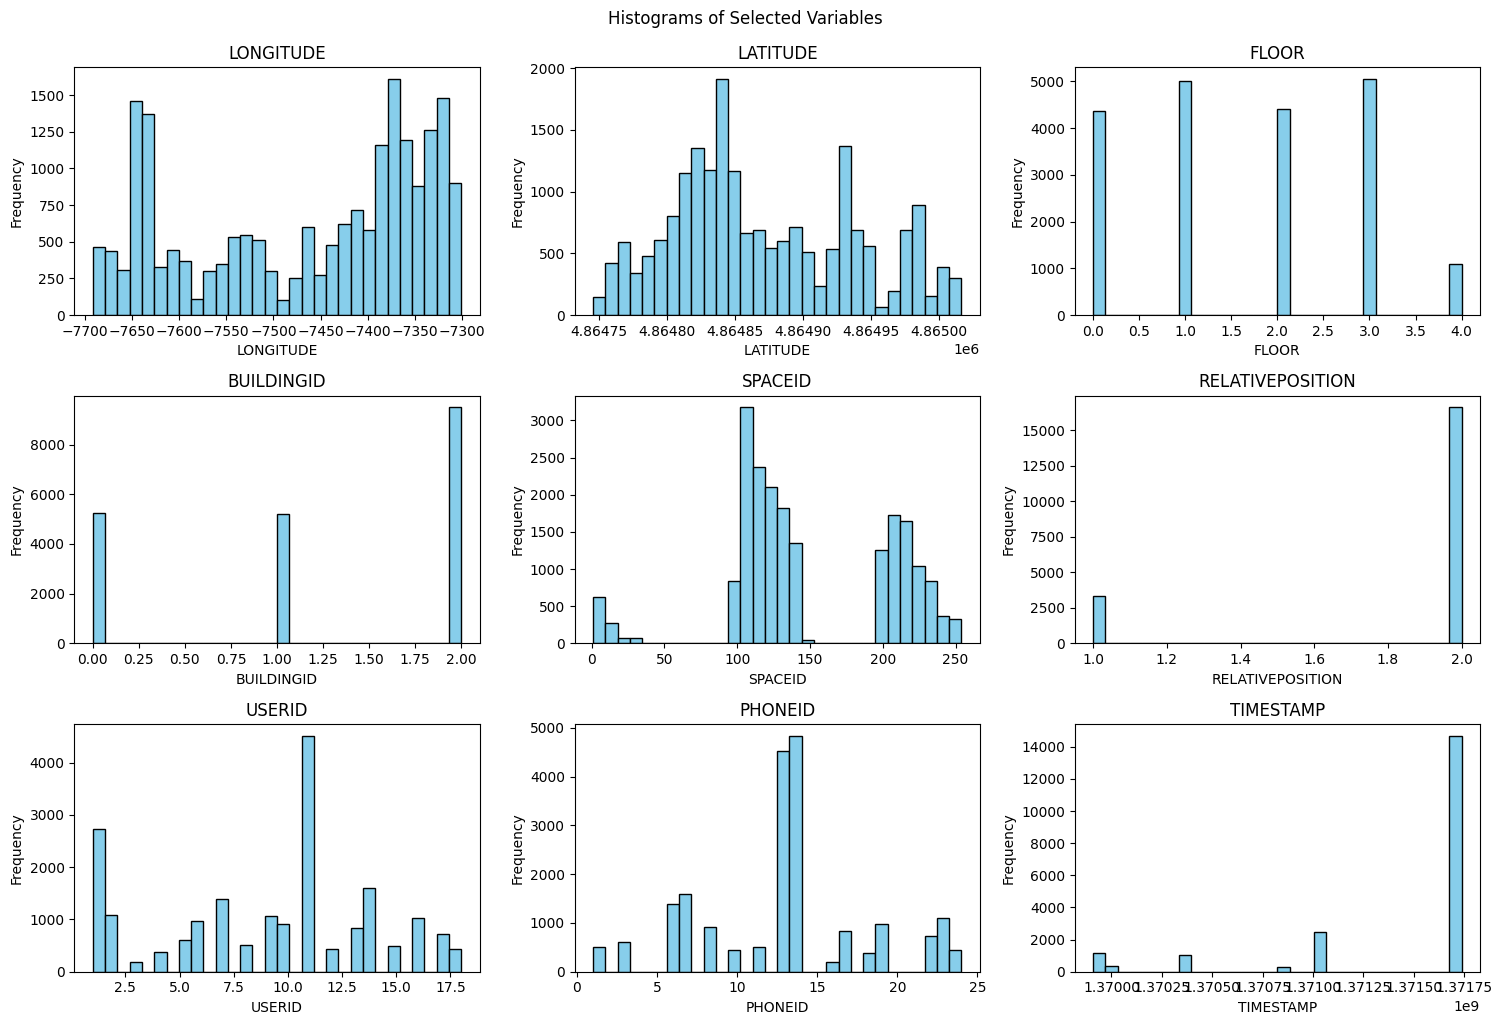

In [21]:
# Define the columns for which you want to create histograms
columns_to_plot = ['LONGITUDE', 'LATITUDE', 'FLOOR', 'BUILDINGID', 
                   'SPACEID', 'RELATIVEPOSITION', 'USERID', 
                   'PHONEID', 'TIMESTAMP']

# Create histograms
plt.figure(figsize=(15, 10))
for i, column in enumerate(columns_to_plot):
    plt.subplot(3, 3, i + 1)  # Create a grid of 3x3 for subplots
    plt.hist(data[column], bins=30, color='skyblue', edgecolor='black')
    plt.title(column)
    plt.xlabel(column)
    plt.ylabel('Frequency')

plt.tight_layout()  # Adjust subplots to fit in to the figure area.
plt.suptitle("Histograms of Selected Variables", y=1.02)  # Add a main title
plt.show()

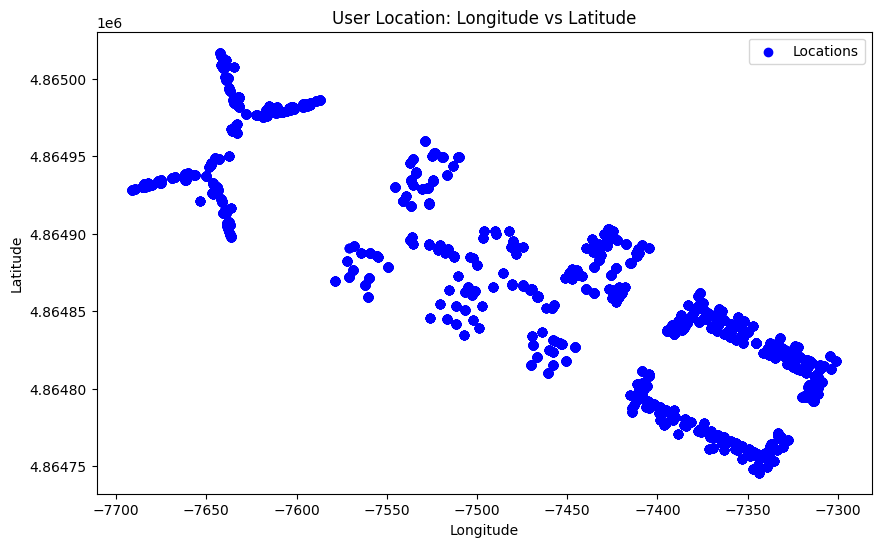

In [26]:
# Scatter plot for Longitude vs Latitude
plt.figure(figsize=(10, 6))
plt.scatter(data['LONGITUDE'], data['LATITUDE'], c='blue', label='Locations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('User Location: Longitude vs Latitude')
plt.legend()
plt.show() 